In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_probability as tfp

D:\Software\anaconda3\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [214]:
class KANLayer7(tf.Module):
    def __init__(self, 
                 inpDim, 
                 outDim, 
                 GInterval, 
                 p,
                 gridRange = [-1.0, 1.0],
                 intDivs = 10,
                 intPointNum = 1000,
                 name = "", 
                 seed = 100):
        super().__init__(name=name)
        self.inpDim = tf.constant(inpDim)
        self.outDim = tf.constant(outDim)
        self.G = tf.constant(GInterval)
        self.p = tf.constant(p)
        self.seed = seed
        stddev = tf.math.sqrt(2 / (inpDim + outDim))
        self.gridRange = gridRange
        
        #Defining Variables
        self.W = tf.Variable(tf.random.normal([self.inpDim, self.outDim], mean = 0.0, stddev = stddev, seed = self.seed), name = name+"_W")
        self.Phi = tf.Variable(tf.random.normal([self.inpDim, self.outDim, self.G], 
                               mean = 0.0, stddev = 1, seed = self.seed), name = self.name+"_Phi")

        #Lazy construction of functions to integrate input signatures (Find better way this is shit)
        self.BSplineFunc = [self.BSpline0, self.BSpline1, self.BSpline2, self.BSpline3][self.p]
        self.Spline = tf.function(self.SplineTemp, input_signature=(tf.TensorSpec(shape=[None, self.inpDim], dtype=tf.float32),))
        self.dot_matmul = tf.function(self.dot_matmulTemp, input_signature=(tf.TensorSpec(shape=[None, self.inpDim, self.G], dtype=tf.float32),
                                                                           tf.TensorSpec(shape=[self.inpDim, self.outDim, self.G], dtype=tf.float32)))

        self.intPointNum = intPointNum
        self.intDivs = tf.constant(intDivs)
        self.InitializeSplineGrids()
        
    def InitializeSplineGrids(self):
        #define grid Integral Variables for regularization calculations
        self.BSplineGridInt = tf.zeros([self.G, self.intDivs], tf.float32)
        self.SiLuGridInt = tf.zeros([1, self.intDivs], tf.float32)
        self.IntPointCount = tf.zeros([self.inpDim, self.intDivs], tf.int32) #This will store the count of the points that lie in certain ranges
        self.InitializeBSplineGridInt()

    #@tf.function
    def InitializeBSplineGridInt(self):
        GdeltaI = tf.cast((self.gridRange[1] - self.gridRange[0]), tf.float32)/tf.cast(self.intDivs, tf.float32)
        GdeltaJ = tf.cast((self.gridRange[1] - self.gridRange[0]), tf.float32)/tf.cast(self.G+self.p, tf.float32)
        for i in tf.range(self.intDivs):
            Ti = GdeltaI * tf.cast(i, tf.float32) + self.gridRange[0]
            points = tf.random.uniform([self.intPointNum, 1], minval = Ti, maxval = Ti+GdeltaI)
            for j in tf.range(0, self.G):
                Tj = GdeltaJ * tf.cast(j, tf.float32) + self.gridRange[0]
                temp0 = tf.reduce_mean(self.BSplineFunc(points, tf.expand_dims(tf.repeat(Tj, self.intPointNum, axis = 0), axis = 1), GdeltaJ))
                self.BSplineGridInt = tf.tensor_scatter_nd_update(self.BSplineGridInt, [tf.concat([[j], [i]], axis = 0)], [temp0])
            
            silu = tf.reduce_mean(points / (1 + tf.exp(-points)))
            self.SiLuGridInt = tf.tensor_scatter_nd_update(self.SiLuGridInt, [tf.concat([[0], [i]], axis = 0)], [silu])
        
                

    def dot_matmulTemp(self, A, B):
        A0 = tf.squeeze(tf.slice(A, [0, 0, 0], [self.inpDimN, self.inpDim, 1]), axis = 2)
        B0 = tf.squeeze(tf.slice(B, [0, 0, 0], [self.inpDim, self.outDim, 1]), axis = 2)
        Y = tf.matmul(A0, B0)
        i = tf.constant(1)
        while(i < self.G):
            A0 = tf.squeeze(tf.slice(A, [0, 0, i], [self.inpDimN, self.inpDim, 1]), axis = 2)
            B0 = tf.squeeze(tf.slice(B, [0, 0, i], [self.inpDim, self.outDim, 1]), axis = 2)
            Y = Y + tf.matmul(A0, B0 * self.W)
            i+=1
        return Y

    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None], dtype = tf.float32), 
                                  tf.TensorSpec(shape=[None, None], dtype = tf.float32),
                                  tf.TensorSpec(shape=[], dtype = tf.float32)))
    def BSpline0(self, T, Ti, Gdelta):
        temp1 = tf.cast(tf.where(((Ti <= T) & (T < (Ti + Gdelta))), 1.0, 0.0), tf.float32)
        return temp1
        
    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None], dtype = tf.float32), 
                                  tf.TensorSpec(shape=[None, None], dtype = tf.float32),
                                  tf.TensorSpec(shape=[], dtype = tf.float32)))
    def BSpline1(self, T, Ti, Gdelta):
        temp0 = 1 * Gdelta
        diff0 = (T - Ti) / temp0
        diff1 = (Ti + temp0 + Gdelta - T)/temp0
        temp2 = ( diff0 * self.BSpline0(T, Ti, Gdelta) ) + ( diff1 * self.BSpline0(T, Ti+Gdelta, Gdelta) )
        return temp2

    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None], dtype = tf.float32), 
                                  tf.TensorSpec(shape=[None, None], dtype = tf.float32),
                                  tf.TensorSpec(shape=[], dtype = tf.float32)))
    def BSpline2(self, T, Ti, Gdelta):
        temp0 = 2 * Gdelta
        diff0 = (T - Ti) / temp0
        diff1 = (Ti + temp0 + Gdelta - T)/temp0
        temp2 = ( diff0 * self.BSpline1(T, Ti, Gdelta) ) + ( diff1 * self.BSpline1(T, Ti+Gdelta, Gdelta) )
        return temp2
        
    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None], dtype = tf.float32), 
                                  tf.TensorSpec(shape=[None, None], dtype = tf.float32),
                                  tf.TensorSpec(shape=[], dtype = tf.float32)))
    def BSpline3(self, T, Ti, Gdelta):
        temp0 = 3 * Gdelta
        diff0 = (T - Ti) / temp0
        diff1 = (Ti + temp0 + Gdelta - T)/temp0
        temp2 = ( diff0 * self.BSpline2(T, Ti, Gdelta) ) + ( diff1 * self.BSpline2(T, Ti+Gdelta, Gdelta) )
        return temp2
    
    def SplineTemp(self, X):
        Gdelta = tf.cast((self.gridRange[1] - self.gridRange[0]), tf.float32)/tf.cast(self.G+self.p, tf.float32)

        #Do Head Count  for normalization
        GdeltaD = tf.cast((self.gridRange[1] - self.gridRange[0]), tf.float32)/tf.cast(self.intDivs, tf.float32)
        PCount = tf.cast(tf.floor((X - self.gridRange[0])/GdeltaD), tf.int32)
        lowCount = tf.reduce_sum(tf.where(PCount < 0, 1, 0), axis = 0)
        highCount = tf.reduce_sum(tf.where(PCount >= (self.intDivs), 1, 0), axis = 0)
        PCount = tf.maximum(PCount, 0)
        PCount = tf.minimum(PCount, self.intDivs-1)
        
        self.IntPointCount = tf.zeros([self.inpDim, self.intDivs], tf.int32)
        PLocs = tf.expand_dims(tf.transpose(tf.repeat(tf.expand_dims(tf.range(self.inpDim), axis = 1), 
                                                    self.inpDimN, axis = 1)), 
                                          axis = 2)
        PLocs = tf.concat([PLocs, tf.expand_dims(PCount, axis = 2)], axis = 2)
        self.IntPointCount = tf.tensor_scatter_nd_add(self.IntPointCount, PLocs, tf.ones([self.inpDimN, self.inpDim], dtype = tf.int32))
        PLocs = tf.expand_dims(tf.range(self.inpDim), axis = 1)
        PLocs = tf.concat([PLocs, tf.zeros([self.inpDim, 1], tf.int32)], axis = 1)
        self.IntPointCount = tf.tensor_scatter_nd_add(self.IntPointCount, PLocs, -lowCount)
        PLocs = tf.expand_dims(tf.range(self.inpDim), axis = 1)
        PLocs = tf.concat([PLocs, (self.intDivs-1)*tf.ones([self.inpDim, 1], tf.int32)], axis = 1)
        self.IntPointCount = tf.tensor_scatter_nd_add(self.IntPointCount, PLocs, -highCount)
        regularLoss = self.RegularizationLoss()
        
        #Start with normal Algorithm
        I = tf.floor((X - self.gridRange[0]) / Gdelta)        
        I = I - tf.cast(self.p, tf.float32)
        I = tf.maximum(I, tf.cast(0, tf.float32))
        I = tf.minimum(I, tf.cast(self.G-self.p-1, tf.float32))
        I = I + tf.cast(self.p, tf.float32)
        Ti = I * Gdelta + self.gridRange[0]
        I = tf.cast(I, tf.int32)
        #Ti = Ti + Gdelta * tf.cast(self.p, tf.float32)

        Res = tf.zeros(tf.concat([[self.inpDimN], [self.inpDim], [self.G]], axis = 0), dtype=tf.float32)
        Ti = Ti + Gdelta
        i = tf.constant(0)
        J = tf.expand_dims(tf.repeat(tf.expand_dims(tf.range(self.inpDimN), axis = 1), self.inpDim, axis = 1), axis = 2)
        K = tf.expand_dims(tf.repeat(tf.expand_dims(tf.range(self.inpDim), axis = 0), self.inpDimN, axis = 0), axis = 2)
        I = tf.expand_dims(I, axis = 2)
        while(i <= self.p):
            Ti = Ti - Gdelta
            Y = self.BSplineFunc(X, Ti, Gdelta)
            temp0 = tf.concat([J, K, (I-i)], axis = 2)
            Res = tf.tensor_scatter_nd_update(Res, temp0, Y)
            i+=1
        Ans = self.dot_matmul(Res, self.Phi)
        return (Ans, regularLoss)

    @tf.function(input_signature=(tf.TensorSpec(shape=[None, None], dtype=tf.float32),))
    def __call__(self, X):
        self.inpDimN = tf.gather_nd(tf.shape(X), [0])
        spline, regularLoss = self.Spline(X)
        silu = X / (1 + tf.exp(-X))
        return (tf.matmul(silu,  self.W) + spline, regularLoss)

    @tf.function
    def RegularizationLoss(self):
        ApproxInt = tf.abs(tf.matmul(self.Phi, self.BSplineGridInt) + tf.squeeze(self.SiLuGridInt, axis = 0))
        PCount = tf.cast(self.IntPointCount, tf.float32)
        PCount = PCount / (1e-9 + tf.repeat(tf.expand_dims(tf.reduce_sum(PCount, axis = 1), axis = 1), self.intDivs, axis = 1))
        PCount = tf.repeat(tf.expand_dims(PCount, axis = 1), self.outDim, axis = 1)
        temp0 = tf.reduce_mean(PCount * ApproxInt, axis = 2) * tf.abs(self.W)
        
        KL = tf.reduce_sum(temp0)
        temp1 = temp0 / (KL + 1e-9)
        temp1 = temp1 * tf.math.log(temp1 + 1e-9)
        KS = tf.reduce_sum(temp1)
        #KW = tf.reduce_sum(tf.abs(self.W))
        return (KL + KS)

    #@tf.function
    def SplineFromGVals(self, X, AVals, gridRange, p, G, func):
        dist = (gridRange[1] - gridRange[0]) / tf.cast(p + G, tf.float32)
        #func = [self.BSpline0, self.BSpline1, self.BSpline2, self.BSpline3][p]
        tempX = tf.cast(tf.repeat(tf.expand_dims(X, axis = 1), G, axis = 1), tf.float32)
        siz = tf.gather(tf.shape(X), 0)
        tempXi = tf.transpose(tf.repeat(tf.expand_dims(tf.range(0, G, 1.0)*dist + gridRange[0], axis = 1), siz, axis = 1))
        return tf.matmul(tf.cast(AVals, tf.float32), tf.transpose(func(tempX, tempXi, dist)))
    
    def UpdateGrid(self, Gnew, Pnew, gridRange, X_Y, addRandomness = False, stddev = 0.0):

        #Define the array (can also set this block to constant as the Arr value doesnt really change)
        X = tf.linspace(-0.25, 1.25, 100000, axis = 0)
        Arr = np.zeros([4, 5])
        func = [self.BSpline0, self.BSpline1, self.BSpline2, self.BSpline3]
        for p in range(4):
            for a in range(5):
                Y = func[p](tf.expand_dims(X, axis = 1), 
                            tf.zeros([100000, 1], tf.float32), 
                            1/(p+1)) * func[p](tf.expand_dims(X, axis = 1), 
                                               tf.ones([100000, 1], tf.float32) * a/(p+1), 
                                               1/(p+1))
                Y = tf.squeeze(Y, axis = 1)
                Arr[p][a] = tfp.math.trapz(Y, X).numpy()
        
        #Block to make the inverse matrix for multiplication later on
        MulArr = np.zeros([Gnew, Gnew])
        temp = (Gnew+Pnew)/((Pnew+1) * (gridRange[1] - gridRange[0]))
        for i in range(Gnew):
            for j in range(Gnew):
                MulArr[i][j] = Arr[Pnew][np.minimum((Pnew+1), np.abs(i-j))] / temp
        invMulArr = tf.cast(tf.linalg.inv(MulArr), tf.float32)

        #Calculate the Spline for Phi G Values
        N = 2000
        X = tf.linspace(gridRange[0], gridRange[1], N, axis = 0)
        func = [self.BSpline0, self.BSpline1, self.BSpline2, self.BSpline3][self.p]
        Y = self.SplineFromGVals(X, self.Phi, self.gridRange, self.p, self.G, func)
        Y = tf.repeat(tf.expand_dims(Y, axis = 2), Gnew, axis = 2)

        #Calculate All the BSplines to Multiply
        func = [self.BSpline0, self.BSpline1, self.BSpline2, self.BSpline3][Pnew]
        Gdelta = (gridRange[1] - gridRange[0]) / (Gnew + Pnew)
        B = []
        for i in range(Gnew):
            B.append(tf.squeeze(func(tf.expand_dims(X, axis = 1), tf.ones([N, 1]) * (gridRange[0] + tf.cast(i*(Gdelta), tf.float32)), Gdelta), 
                                axis = 1))
        B = tf.constant(np.array(B), tf.float32)      

        #Integrate the Y*B and calculate the new Phi from matmul
        IntSpace = tfp.math.trapz((Y*B), tf.ones(tf.shape(Y), tf.float32) * X, axis = 3)
        PhiN = tf.matmul(IntSpace, tf.transpose(invMulArr))

        xPos, yPos = X_Y
        func = [self.BSpline0, self.BSpline1, self.BSpline2, self.BSpline3][Pnew]
        Yinv = self.SplineFromGVals(X, PhiN, gridRange, Pnew, Gnew, func)
        plt.plot(X, Y[xPos, yPos, 0])
        plt.plot(X, Yinv[xPos, yPos])

        return {"Phi": PhiN, "W": self.W}

    def assignValues(self, Vars):
        if "Phi" in Vars:
            print("Phi")
            self.Phi.assign(Vars["Phi"])
        if "W" in Vars:
            print("W")
            self.W.assign(Vars["W"])
        self.InitializeSplineGrids()
        

In [215]:
outDim = 2
kan0 = KANLayer7(1, 
                 outDim, 
                 GInterval = 5, 
                 p = 1, 
                 intDivs = 20, 
                 intPointNum = 10000,
                 name = "layer0", 
                 seed = 100) 

In [216]:
N = 10000
X = tf.random.uniform([N, 1], minval = -2, maxval = 2)
X = tf.sort(X, axis = 0)

time0 = tf.timestamp()
with tf.GradientTape() as tape:
    Y0, regloss = kan0(X)
timedelt = tf.timestamp() - time0

dY_dK = tape.gradient(Y0, kan0.trainable_variables)

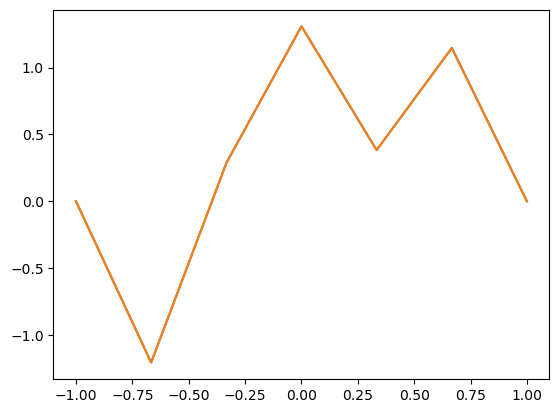

In [243]:
P = 1
G = 11
gridRange = [-1.0, 1.0]
Vars = kan0.UpdateGrid(G, P, tf.constant(gridRange), (0, 1))

In [240]:
kan1 = KANLayer7(1, 
                 outDim, 
                 GInterval = G, 
                 p = P, 
                 intDivs = 20, 
                 intPointNum = 10000,
                 gridRange = gridRange,
                 name = "layer0", 
                 seed = 100)

#Vars = {"Phi1": kan0.Phi, "W": kan0.W}
#Vars["W"] = kan0.W
kan1.assignValues(Vars)

Phi
W


In [241]:
time0 = tf.timestamp()
with tf.GradientTape() as tape:
    Y1, regloss = kan1(X)
timedelt = tf.timestamp() - time0

dY_dK = tape.gradient(Y1, kan1.trainable_variables)

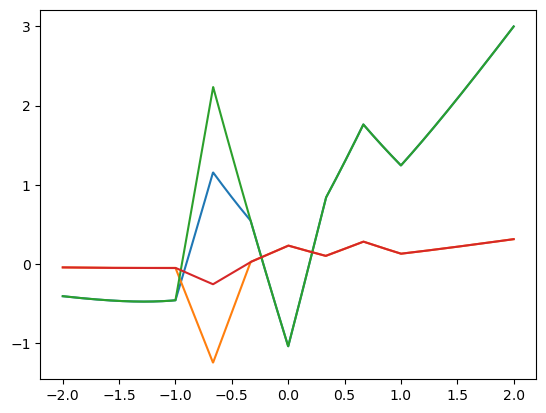

In [242]:
plt.plot(X, Y0)
plt.plot(X, Y1)

Negative Ranges not working here